This notebook requires jdc: https://alexhagen.github.io/jdc/

Moreover give a look at http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

## Graph in python with tigraph ##

What follows is basically trigraph from the excellent blog  https://triangleinequality.wordpress.com/2013/08/21/graphs-as-objects-in-python/, only minor changes from the code in the post. Mainly docstring documentation, compatibiltiy with python3, and some performances hacks. 

In [48]:
import jdc as jdc

In [49]:
class BasicNode: 
    """BasicNode class: should be interfaced to from a graph object
    
    Args: 
        content (set):
        labels (set):
    """
    def __init__(self, content=None, labels=None):
        self.content = content
        self.incident_edges =set([])
        self.incident_outward_edges=set([])
        self.incident_inward_edges=set([])
        if labels is None:
            self.labels=set([])
        else:
            self.labels=labels
 
    def add_edge(self,Edge):
        """ add_edge BasicNode method: add an edge to the set incident_edges and keep track of whether is inward
        or outward incident. 
        
        Args: 
            Edge(obj): an object of the class Edge as defined in Graph (default is BasicEdge) 
        """
        if self in Edge.ends:
            self.incident_edges.add(Edge)
            if Edge.source()==self:
                self.incident_outward_edges.add(Edge)
            else:
                self.incident_inward_edges.add(Edge)
        else:
            print('Cannot add edge to vertex, vertex not in ends.')
 
    def remove_edge(self,Edge):
        self.incident_edges.discard(Edge)
 
    def get_neighbors(self):
        """get_neighbors BasicNode method: return the neighborood of the vertex
        The neighborhood of a vertex v is an induced subgraph of the graph, formed by all vertices adjacent to v
        
        Returns: 
            list of neighbors vertices 
        """
        neighbors = [Edge.ends for Edge in self.incident_edges]
        #unique_neighbors = list(set(reduce(lambda x,y: x+y, neighbors))) #Original, appear to be slower 
        unique_neighbors = list(set(chain(*neighbors))) #This appears a much faster way to flatten a list 
        if [self, self] not in neighbors: #checks for a loop
            unique_neighbors.remove(self)
        return unique_neighbors
 
    def get_targets(self):
        #targets = set(map(lambda x: x.target(), self.incident_outward_edges))
        targets = set([Edge.target() for Edge in self.incident_outward_edges]) #Appears slighltly faster 
        return targets
 
    def get_sources(self):
        #sources = set(map(lambda x: x.source(), self.incident_inward_edges))
        sources = set([Edge.source() for Edge in self.incident_inward_edges]) #Appears slighlty faster 
        return sources
 
    def add_label(self, label):
        self.labels.add(label)
 
    def remove_label(self, label):
        self.labels.discard(label)

In [50]:
class BasicEdge: 
    """BasicEdge class: should be interfaced to from a graph object
    
    Args: 
        content (set):
        ends(list): The vertex endpoints of the edge. Vertices are ??? (I guess the objects)
        labels (set):
    """
    def __init__(self, content=None, ends=[], labels=None):
        self.content = content
        self.ends = ends
        if labels is None:
            self.labels=set([])
        else:
            self.labels=labels
 
    def source(self):
        return self.ends[0]
 
    def target(self):
        return self.ends[1]
 
    def add_label(self, label):
        self.labels.add(label)
 
    def remove_label(self, label):
        self.labels.discard(label)


The following decorators are well explained in https://triangleinequality.wordpress.com/2013/08/19/decorators-in-python-and-syncing-objects/

In [40]:
def update_up(class_method):
    def inner(self, *args, **kwargs):
        method_name = class_method.__name__ 
        class_method(self, *args, **kwargs)
        for Supergraph in self.supergraphs:
            getattr(Supergraph, method_name)(*args, **kwargs)
    return inner

def update_up_down(class_method):
    def inner(self, *args, **kwargs):
        method_name = class_method.__name__ 
        if class_method(self, *args, **kwargs):
            for Supergraph in self.supergraphs:
                getattr(Supergraph, method_name)(*args, **kwargs)
            for Subgraph in self.subgraphs:
                getattr(Subgraph, method_name)(*args, **kwargs)
    return inner

In [51]:
import numpy as np
class Graph(object):
    """Graph class: Vertex and Edge classes are passed to the Graph class during initialization. Custom behavior is
    Vertex = BasicNode, Edge=BasicEdge 
    
    Args: 
        subgraphs (set):
        supergraphs (set):
        vertices (set): set of Vertex instances (default Vertex=BasicNode)
        edges (set): 
        Vertex: 
        Edge
    """
    def __init__(self, subgraphs=None, supergraphs=None, vertices=None, edges=None, Vertex=BasicNode, Edge=BasicEdge):
 
        if edges == None:
            edges = []
        self.edges=set(edges)
        if vertices == None:
            vertices = []
        self.vertices=vertices
        if subgraphs == None:
            subgraphs=[]
        self.subgraphs =set(subgraphs)
        if supergraphs == None:
            supergraphs =[]
        self.supergraphs=set(supergraphs)
        for Supergraph in supergraphs:
            Supergraph.add_subgraph(self)
        for Subgraph in subgraphs:
            Subgraph.add_supergraph(self)
        self.vertex_dict = {}
        self.edges_dict={}
        self.Vertex = Vertex
        self.Edge = Edge
 
    @update_up
    def create_vertex(self):
        self.vertices.append(self.Vertex())
 
    def create_vertices(self, no_create):
        for i in range(no_create):
            self.create_vertex()
 
    @update_up
    def add_vertex(self, Vertex):
        if Vertex in self.vertices:
            return
        self.vertices.append(Vertex)
 
    @update_up
    def create_edge(self, ends):
        NewEdge=self.Edge(ends=ends)
        self.edges.add(NewEdge)
        for Vertex in ends:
            Vertex.add_edge(NewEdge)
 
    @update_up_down
    def remove_edge(self, Edge):
        if not Edge in self.edges:
            return False
        self.edges.discard(Edge)
        return True
 
    def get_incident_edges(self, Vertex):
        incident_edges = Vertex.incident_edges & self.edges
        return incident_edges
 
    @update_up_down
    def remove_vertex(self, Vertex):
        if Vertex not in self.vertices:
            return False
        edges_to_remove = self.get_incident_edges(Vertex)
        for Edge in edges_to_remove:
            self.remove_edge(Edge)
        self.vertices.remove(Vertex)
        return True
 
    def get_vertex_neighbors(self, Vertex):
        neighbors = (Vertex.get_neighbors() & set(self.vertices))
        return neighbors
 
    def get_degree(self, Vertex):
        return len(self.get_incident_edges(Vertex))
 
    def get_number_vertices(self):
        return len(self.vertices)
 
    def get_number_edges(self):
        return len(self.edges)

    def get_adjacency_matrix(self):
        adj_list = [self.get_adjacency_list_of_vertex(Vertex) for Vertex in self.vertices]
        #https://stackoverflow.com/questions/1247486/python-list-comprehension-vs-map
        #adj_list = list(map(lambda x: self.get_adjacency_list_of_vertex(x), self.vertices))
        adj_mat = np.array(adj_list)
        return adj_mat
 
    def get_adjacency_matrix_as_list(self):
        return self.get_adjacency_matrix().tolist()
 
    def set_adjacency_list(self, adj_list):
        self.vertices=[]
        self.edges=[]
 
    def add_subgraph(self,Subgraph):
        self.subgraphs.add(Subgraph)
 
    def add_supergraph(self, Supergraph):
        self.supergraphs.add(Supergraph)
 
    def is_in(self,vertex_or_edge):
        if (vertex_or_edge in self.edges) or (vertex_or_edge in self.vertices):
            return True
        else:
            return False
 
    def get_incident_outward_edges(self,Vertex):
        return (Vertex.incident_outward_edges & self.edges)
 
    def get_incident_inward_edges(self,Vertex):
        return (Vertex.incident_inward_edges & self.edges)
 
    def get_vertex_targets(self, Vertex):
        targets = (Vertex.get_targets() & set(self.vertices))
        return targets
 
    def get_vertex_sources(self, Vertex):
        sources = (Vertex.get_sources() & set(self.vertices))
        return sources
 
    def add_vertex_label(self, vertex, label):
        self.vertex_dict[label] = vertex
        vertex.add_label(label)
 
    def get_vertex(self,label):
        if label in self.vertex_dict.keys():
            return self.vertex_dict[label]
        else:
            return None
 
    def get_vertex_label(self, vertex):
        labels = vertex.get_labels()
        labels = labels & self.vertex_dict.keys()
        labels = filter(lambda x: self.get_vertex[x]==vertex,labels)
 
    def remove_vertex_label(self, label):
        vertex=self.vertex_dict.pop(label, 'Not Found')
        if vertex == 'Not Found':
            return
        else:
            vertex.remove_label(label)
 
    def add_edge_label(self, edge, label):
        self.edge_dict[label] = edge
        edge.add_label(label)
 
    def get_edge(self,label):
        if label in self.edge_dict.keys():
            return self.edge_dict[label]
        else:
            return None
 
    def get_edge_label(self, edge):
        labels = edge.get_labels()
        labels = labels & self.edge_dict.keys()
        labels = filter(lambda x: self.get_edge[x]==edge,labels)
 
    def remove_edge_label(self, label):
        edge=self.edge_dict.pop(label, 'Not Found')
        if edge == 'Not Found':
            return
        else:
            edge.remove_label(label)

In [42]:
import igraph as ig
 
class UnDirGraph(Graph, object):
 
    def get_adjacency_list_of_vertex(self, Vertex):
            N = self.get_number_vertices()
            adj_list= [0 for x in range(N)]
            incident_edges = self.get_incident_edges(Vertex)
            for Edge in incident_edges:
                ends = Edge.ends
                if ends[0] != Vertex:
                    index = self.vertices.index(ends[0])
                else:
                    index = self.vertices.index(ends[1])
                adj_list[index] += 1
            return adj_list
 
    def set_adjacency_matrix(self, adj_mat):
        shape = np.shape(adj_mat)
        if shape[0] != shape[1]:
            print('Wrong shape, expecting square matrix.')
            return
        n = shape[0]
        self.vertices=[]
        self.edges=[]
        self.create_vertices(n)
        for row in range(n):
            Source = self.vertices[row]
            for col  in range(row+1):
                no_edges = adj_mat[row, col]
                Target = self.vertices[col]
                for Edge in range(no_edges):
                    self.create_edge(ends=[Source, Target])
 
    def plot(self):
        A = self.get_adjacency_matrix_as_list()
        convert_to_igraph = ig.Graph.Adjacency(A, mode='undirected')
        return ig.plot(convert_to_igraph)

In [43]:
class DirGraph(Graph):
    def get_incident_outward_edges(self,Vertex):
        return (Vertex.incident_outward_edges & self.edges)
 
    def get_incident_inward_edges(self,Vertex):
        return (Vertex.incident_inward_edges & self.edges)
 
    def get_adjacency_list_of_vertex(self, Vertex):
        N = self.get_number_vertices()
        adj_list= [0 for x in range(N)]
        incident_edges = self.get_incident_outward_edges(Vertex)
        for Edge in incident_edges:
            target = Edge.target()
            index = self.vertices.index(target)
            adj_list[index] += 1
        return adj_list
 
    def set_adjacency_matrix(self, adj_mat):
        shape = np.shape(adj_mat)
        if shape[0] != shape[1]:
            print('Wrong shape, expecting square matrix.')
            return
        n = shape[0]
        self.vertices=[]
        self.edges=[]
        self.create_vertices(n)
        for row, col in range(n):
            no_edges = adj_mat[row, col]
            Source = self.vertices[row]
            Target = self.vertices[col]
            for Edge in range(no_edges):
                self.create_edge(ends=[Source, Target])
 
    def get_vertex_targets(self, Vertex):
        targets = (Vertex.get_targets() & set(self.vertices))
        return targets
 
    def get_vertex_sources(self, Vertex):
        sources = (Vertex.get_sources() & set(self.vertices))
        return sources
 
    def plot(self):
        A = self.get_adjacency_matrix_as_list()
        convert_to_igraph = ig.Graph.Adjacency(A)
        return ig.plot(convert_to_igraph)

Dynamic inheritance, read also the following post: 
https://stackoverflow.com/questions/100003/what-is-a-metaclass-in-python/6581949#6581949

In [44]:
def return_linear_class(directed=False):
    if directed:
        base=DirGraph
    else:
        base=UnDirGraph
    class Linear(base, object):
        def __init__(self, number_vertices=0, number_edges=0, **kwargs):
            super(Linear, self).__init__(**kwargs)
            self.linear_generate(number_vertices, number_edges)
 
        def linear_generate(self,number_vertices, number_edges):
            if (not number_edges ==0) and (not number_vertices==0):
                if not number_vertices == number_edges+1:
                    print('Number of edges and vertices incompatible!')
                    return
                else:
                    self.number_vertices=number_vertices
 
            elif not number_edges==0:
                self.number_vertices = number_edges +1
            else:
                self.number_vertices = number_vertices
 
            self.create_vertices(self.number_vertices)
            for index in range(self.number_vertices -1):
                Source = self.vertices[index]
                Target = self.vertices[index+1]
                self.create_edge([Source, Target])
    return Linear

In [45]:
def create_linear(directed=False, number_vertices=0, number_edges=0,**kwargs):
    linear = return_linear_class(directed)(number_vertices, number_edges,**kwargs)
    return linear

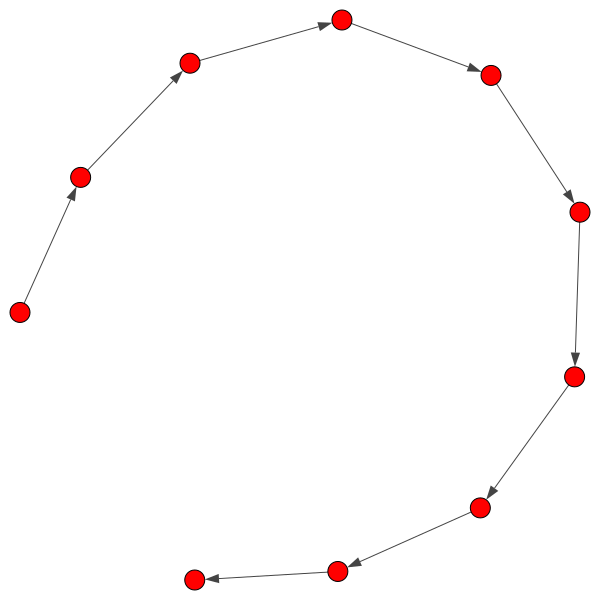

In [46]:
testdir=create_linear(directed=True, number_vertices=10)
testundir=create_linear(directed=False,number_vertices=10)
testdir.plot()

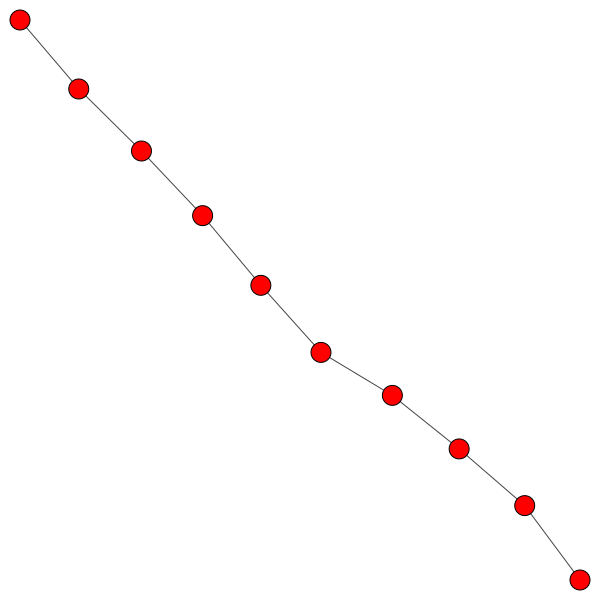

In [47]:
testundir.plot()